# Introduction

# Install and Import Necessary Libraries

In [1]:
! pip install -U pylibjpeg pylibjpeg-openjpeg pylibjpeg-libjpeg pydicom python-gdcm
! pip install --upgrade pydicom

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 85.7 MB/s eta 0:00:00
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
try:
    import pylibjpeg
except:
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}

In [3]:
#!pip install dicomsdl pytorch_lightning timm --no-index --find-links=../input/rbcd-downloads

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

import pydicom
pydicom.__version__

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset

import timm

# Data Access and Analysis

In [5]:
RSNA_2022_path = '/kaggle/input/rsna-breast-cancer-detection/train_images'

In [6]:
df_train = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [7]:
len(df_train)

54706

In [8]:
len(df_train[df_train['cancer'] == 0])

53548

In [9]:
len(df_train[df_train['biopsy'] == 1])

2969

In [10]:
len(df_train[df_train['cancer'] == 1])

1158

In [11]:
len(df_train[df_train['invasive'] == 1])

818

In [12]:
len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])

818

<AxesSubplot:xlabel='class', ylabel='count'>

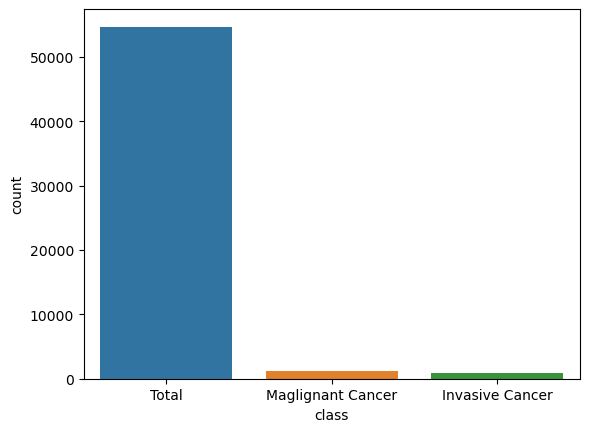

In [13]:
data = pd.DataFrame(np.concatenate([['Total'] * len(df_train) , ['Maglignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

<AxesSubplot:xlabel='class', ylabel='count'>

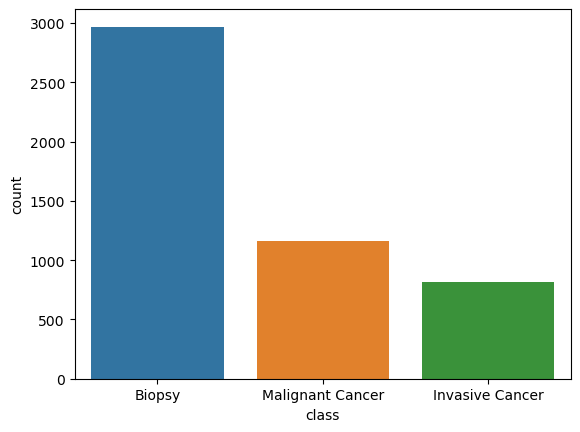

In [14]:
data = pd.DataFrame(np.concatenate([['Biopsy'] * len(df_train[df_train['biopsy'] == 1]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [15]:
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)])

1811

In [16]:
len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 1)])

1158

<AxesSubplot:xlabel='class', ylabel='count'>

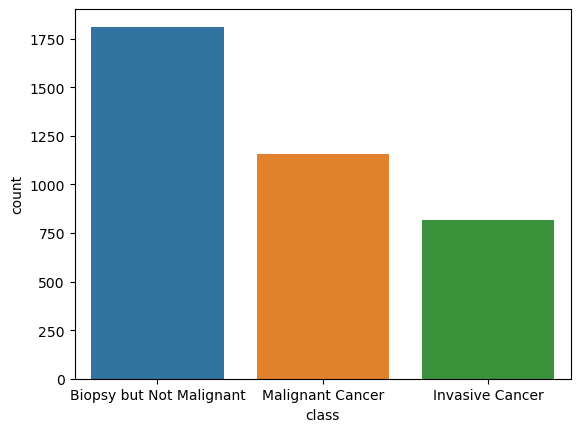

In [17]:
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(df_train[(df_train['biopsy'] == 1) & (df_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(df_train[df_train['cancer'] == 1]), ['Invasive Cancer'] *  len(df_train[(df_train['cancer'] == 1) & (df_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

In [18]:
DF_train = df_train[df_train['biopsy'] == 1].reset_index(drop = True)
DF_train.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,1,10102,453020471,R,CC,40.0,0,1,0,0.0,0,B,49,True
1,1,10102,1181635673,R,MLO,40.0,0,1,0,0.0,0,B,49,True
2,1,10102,1241778584,R,MLO,40.0,0,1,0,0.0,0,B,49,True
3,1,10102,1951607544,R,CC,40.0,0,1,0,0.0,0,B,49,True
4,1,10130,388811999,L,MLO,71.0,1,1,1,0.0,0,B,49,False


In [19]:
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample(1158, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', DF_train.shape[0])

New Data Size: 2316


<AxesSubplot:xlabel='class', ylabel='count'>

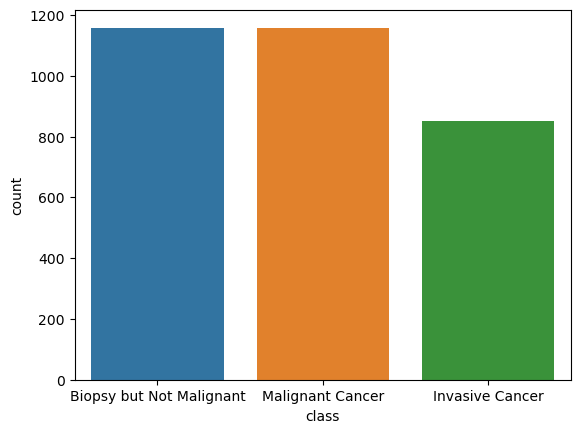

In [20]:
data = pd.DataFrame(np.concatenate([['Biopsy but Not Malignant'] * len(DF_train[(DF_train['biopsy'] == 1) & (DF_train['cancer'] == 0)]) , ['Malignant Cancer'] *  len(DF_train[DF_train['cancer'] == 1]), ['Invasive Cancer'] *  len(DF_train[(DF_train['cancer'] == 1) & (DF_train['invasive'] == 1)])]), columns = ["class"])

sns.countplot(x = 'class', data = data)

# Medical Image Data in DICOM 

In [21]:
dcmfnm = '/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'

ds = pydicom.dcmread(dcmfnm, force = True)
print("Display Meta Information\n", ds)

# Get information with keyword
p_id = ds.PatientID
print("\n>Patient ID=", p_id, type(p_id))

Display Meta Information
 Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.840.113654.2.3.1995.2.12.0
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.840.10009.1.2.3.10006.1.1459541791
(0008, 0023) Content Date                        DA: '20221118'
(0008, 0033) Content Time                        TM: '183901.792591'
(0010, 0020) Patient ID                          LO: '10006'
(0020, 000d) Study Instance UID                  UI: 1.2.840.10009.1.2.3.10006
(0

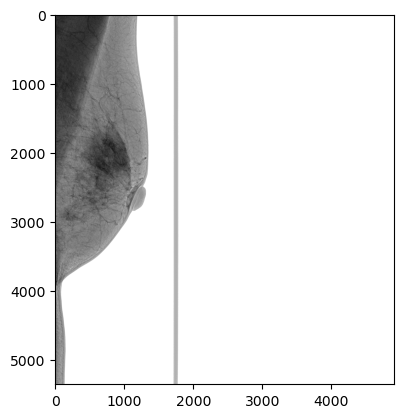

In [22]:
img = ds.pixel_array
plt.imshow(img, cmap = 'gray')
plt.show()

In [23]:
img

array([[1803, 1845, 1874, ..., 3044, 3044, 3044],
       [1834, 1866, 1902, ..., 3044, 3044, 3044],
       [1866, 1894, 1903, ..., 3044, 3044, 3044],
       ...,
       [2250, 2259, 2240, ..., 3044, 3044, 3044],
       [2246, 2256, 2235, ..., 3044, 3044, 3044],
       [2196, 2217, 2226, ..., 3044, 3044, 3044]], dtype=uint16)

In [24]:
img.shape

(5355, 4915)

In [25]:
ds = pydicom.dcmread(os.path.join(RSNA_2022_path + '/' + str(DF_train.loc[0, 'patient_id']) + '/' + str(DF_train.loc[0, 'image_id']) + '.dcm'), force = True)
img = ds.pixel_array.astype(np.float32)
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
img.shape

(4096, 3328)

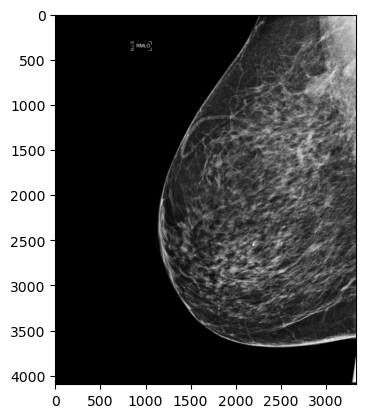

In [27]:
plt.imshow(img, cmap = 'gray')
plt.show()

In [28]:
img = np.resize(img, (1024, 1024))

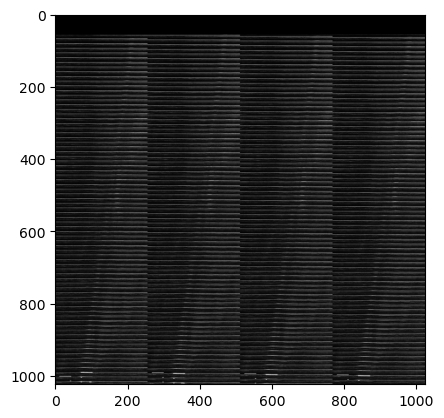

In [29]:
plt.imshow(img, cmap = 'gray')
plt.show()

# Creation of Dataset and Data Loader for Training and Validation

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [31]:
class RSNA_Dataset(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_2022_path + '/' + str(self.img_data.loc[index, 'patient_id']) + '/' + str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True)
        image = ds.pixel_array.astype(np.float32)
        image = np.resize(image, (512, 512))
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [32]:
dataset = RSNA_Dataset(DF_train, RSNA_2022_path, transform)

In [33]:
len(dataset)

2316

In [34]:
import pickle

with open('my_dataset.pickle', 'wb') as output:
    pickle.dump(dataset, output)

In [35]:
x, t = dataset[0]

In [36]:
x

tensor([[[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         ...,
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
          -1.0000e+00, -1.0000e+00],
         [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ...,  1.2430e+03,
           1.8870e+03,  1.3290e+03]]])

In [37]:
type(x), x.dtype, x.shape

(torch.Tensor, torch.float32, torch.Size([1, 512, 512]))

In [38]:
t

tensor(0)

In [39]:
train, val = torch.utils.data.random_split(dataset = dataset, lengths = [1800, 516], generator = torch.Generator().manual_seed(42))

In [40]:
len(train), len(val)

(1800, 516)

In [41]:
can = 0
for i in range(len(val)):
    x, t = val[i]
    if t == 1:
        can += 1
print(can / len(val))        

0.5038759689922481


In [42]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle = False, drop_last = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = 128)

# Creation of Dataset and Visualization (No Resize)

In [43]:
class RSNA_Dataset_Visual(Dataset):
    def __init__(self, img_data, img_path, transform = None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(RSNA_2022_path + '/' + str(self.img_data.loc[index, 'patient_id']) + '/' + str(self.img_data.loc[index, 'image_id']) + '.dcm')
        ds = pydicom.dcmread(img_name, force = True)
        image = ds.pixel_array.astype(np.float32)
        #image = np.resize(image, (512, 512))
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        label = torch.tensor(self.img_data.loc[index, 'cancer'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [44]:
dataset_visual = RSNA_Dataset_Visual(DF_train, RSNA_2022_path, transform)

In [45]:
train_visual, val_visual = torch.utils.data.random_split(dataset = dataset_visual, lengths = [1800, 516], generator = torch.Generator().manual_seed(42))

In [46]:
def img_display(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    #npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

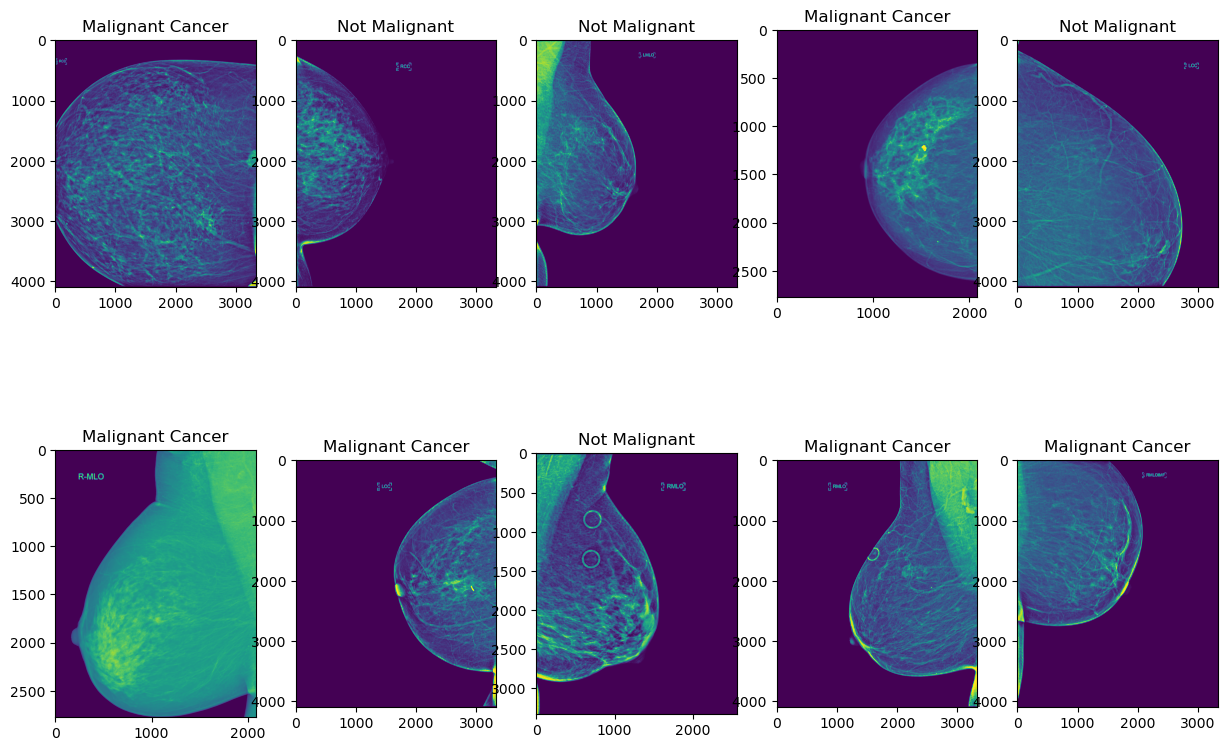

In [47]:
# get some training images
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = train_visual[i]
        ax.imshow(img_display(image).squeeze(0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

# Creation of Model

In [48]:
base_model = timm.create_model('efficientnetv2_s', num_classes = 1280, pretrained = True, in_chans = 1)
for param in base_model.parameters():
    param.requires_grad = False

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(1280, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.base_model(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [50]:
model = Net() # On CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = Net().to(device) # On GPU
print(model)

Net(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
 

# Training and Validation

In [51]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 1, end_factor = 0.2, total_iters = 10)

In [52]:
n_epochs = 8
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs + 1):
    running_loss = 0.0
    #scheduler.step(epoch)
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        #data_, target_ = data_.to(device), target_.to(device) # on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        pred = torch.sigmoid(outputs)
        target = target_.unsqueeze(1).float()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        pred = pred > 0.5
        accuracy = (target == pred).sum().item() / target.size(0)

        if (batch_idx) % 3 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * accuracy)
    train_loss.append(running_loss / total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * accuracy):.4f}')
    batch_loss = 0
    total_t = 0
    correct_t = 0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (val_loader):
            #data_t, target_t = data_t.to(device), target_t.to(device) # on GPU
            outputs_t = model(data_t)
            pred_t = torch.sigmoid(outputs_t)
            target_t = target_t.unsqueeze(1).float()
            loss_t = criterion(pred_t, target_t)
            batch_loss += loss_t.item()
            pred_t = pred_t > 0.5
            accuracy_t = (target_t == pred_t).sum().item() / target_t.size(0)
        val_acc.append(100 * accuracy_t)
        val_loss.append(batch_loss / len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * accuracy_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'cancer_classification.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/8], Step [0/14], Loss: 0.6958
Epoch [1/8], Step [3/14], Loss: 0.6881
Epoch [1/8], Step [6/14], Loss: 0.6907
Epoch [1/8], Step [9/14], Loss: 0.6902
Epoch [1/8], Step [12/14], Loss: 0.7002

train loss: 0.6954, train acc: 60.1562
validation loss: 0.6914, validation acc: 75.0000

Detected network improvement, saving current model
Epoch 2

Epoch [2/8], Step [0/14], Loss: 0.6902
Epoch [2/8], Step [3/14], Loss: 0.6861
Epoch [2/8], Step [6/14], Loss: 0.6890
Epoch [2/8], Step [9/14], Loss: 0.6953
Epoch [2/8], Step [12/14], Loss: 0.6831

train loss: 0.6940, train acc: 56.2500
validation loss: 0.6891, validation acc: 75.0000

Detected network improvement, saving current model
Epoch 3

Epoch [3/8], Step [0/14], Loss: 0.6879
Epoch [3/8], Step [3/14], Loss: 0.6918
Epoch [3/8], Step [6/14], Loss: 0.6836
Epoch [3/8], Step [9/14], Loss: 0.6887
Epoch [3/8], Step [12/14], Loss: 0.6770

train loss: 0.6921, train acc: 63.2812
validation loss: 0.6869, validation acc: 75.0000

Detected netw

# Save and Visualize the Results

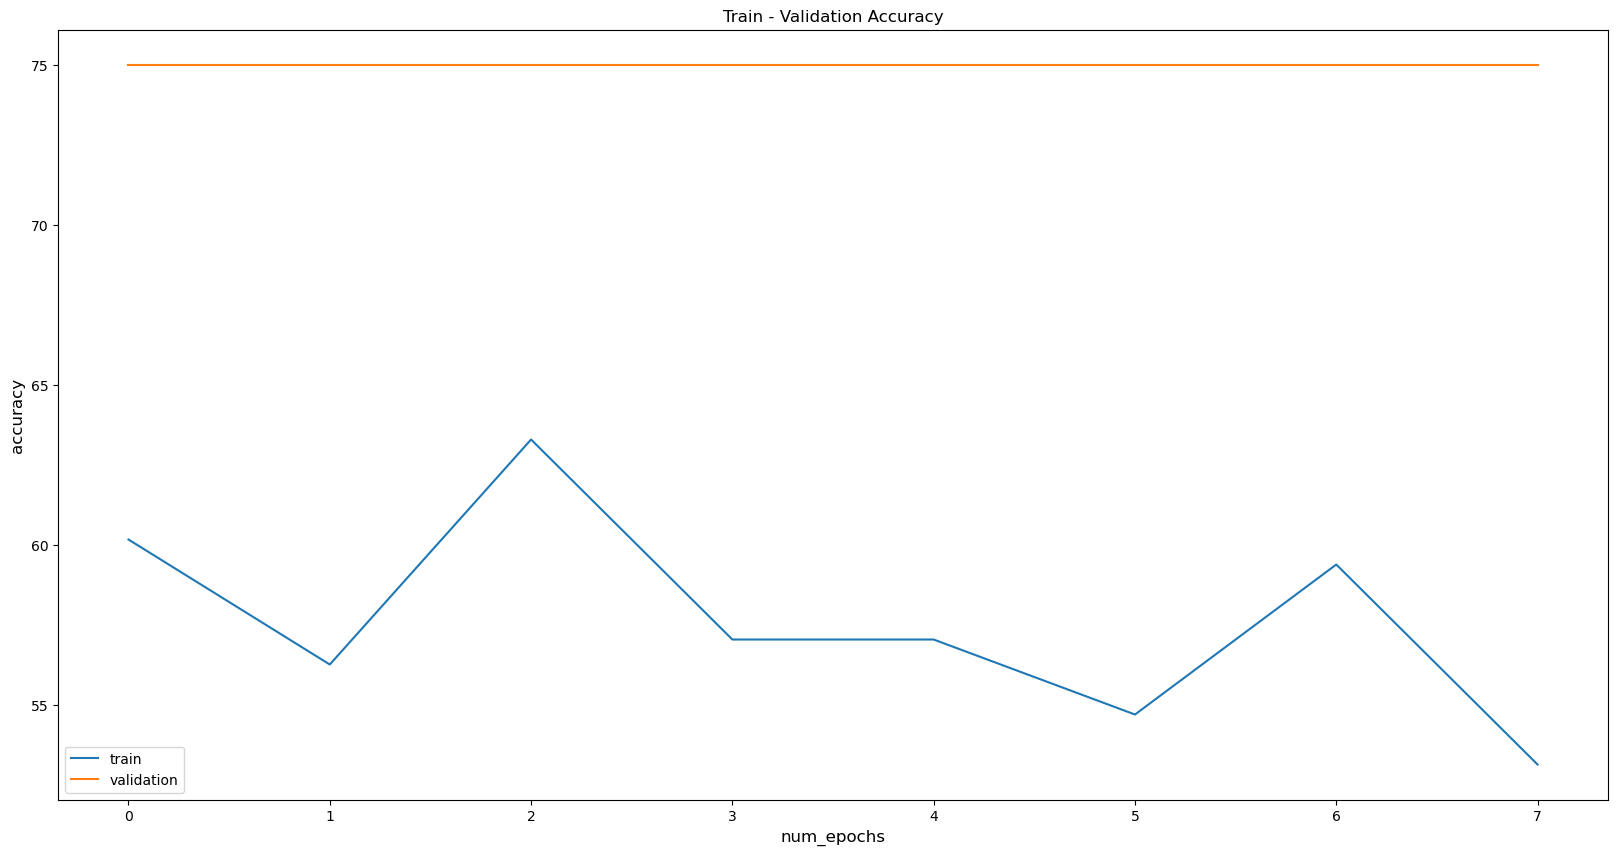

In [53]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label = 'train')
plt.plot(val_acc, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('accuracy', fontsize = 12)
plt.legend(loc = 'best')

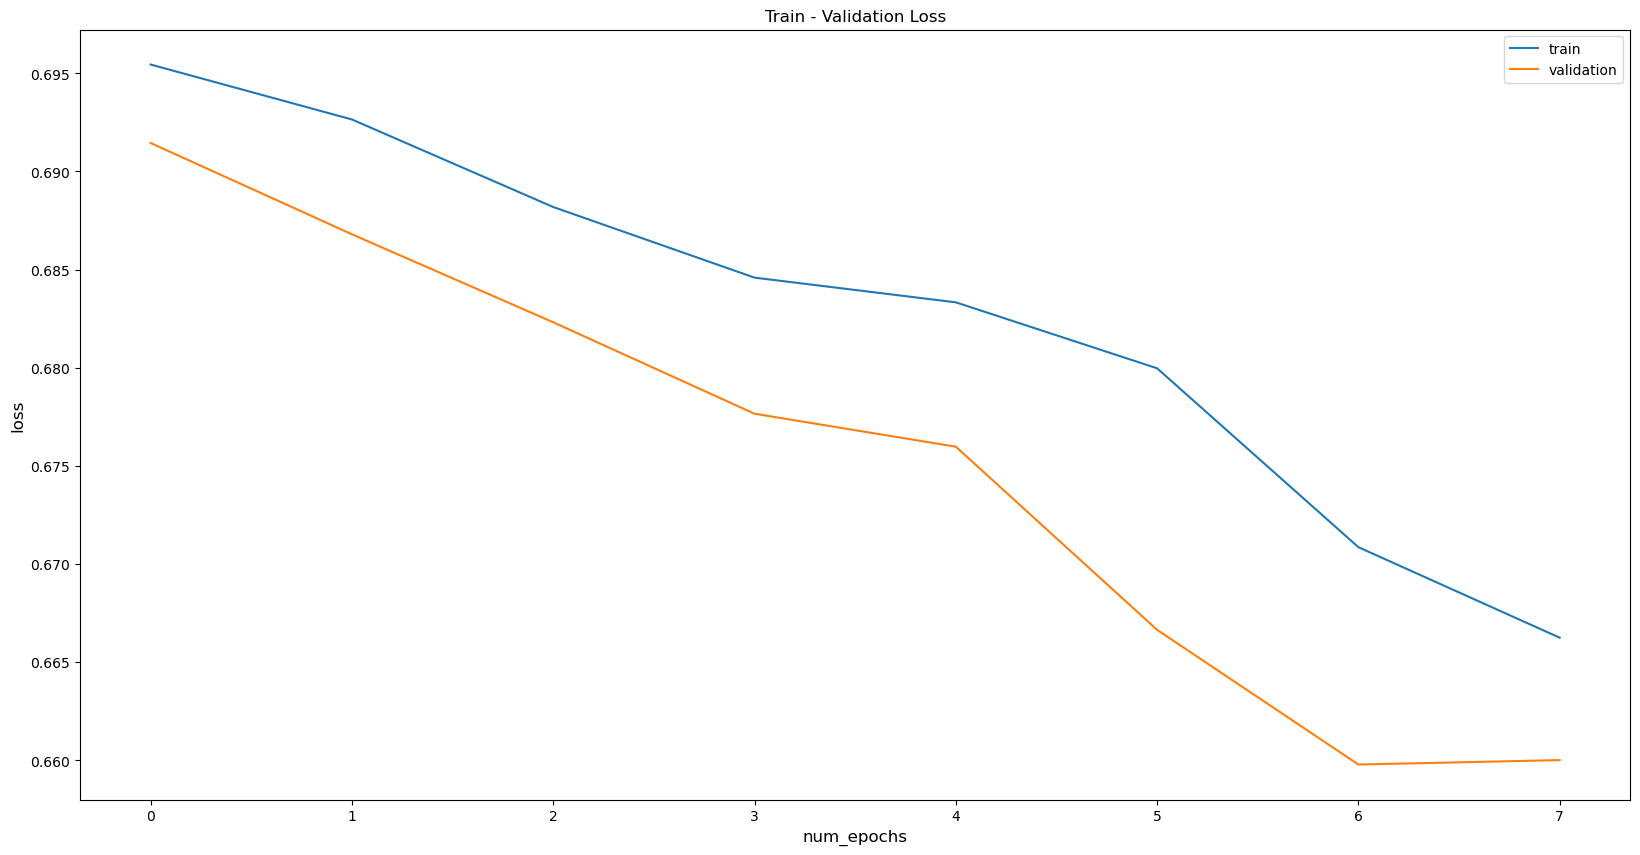

In [54]:
fig = plt.figure(figsize = (20, 10))
plt.title("Train - Validation Loss")
plt.plot(train_loss, label = 'train')
plt.plot(val_loss, label = 'validation')
plt.xlabel('num_epochs', fontsize = 12)
plt.ylabel('loss', fontsize = 12)
plt.legend(loc = 'best')

In [55]:
# Importing trained Network with better loss of validation
model.load_state_dict(torch.load('cancer_classification.pt'))

<All keys matched successfully>

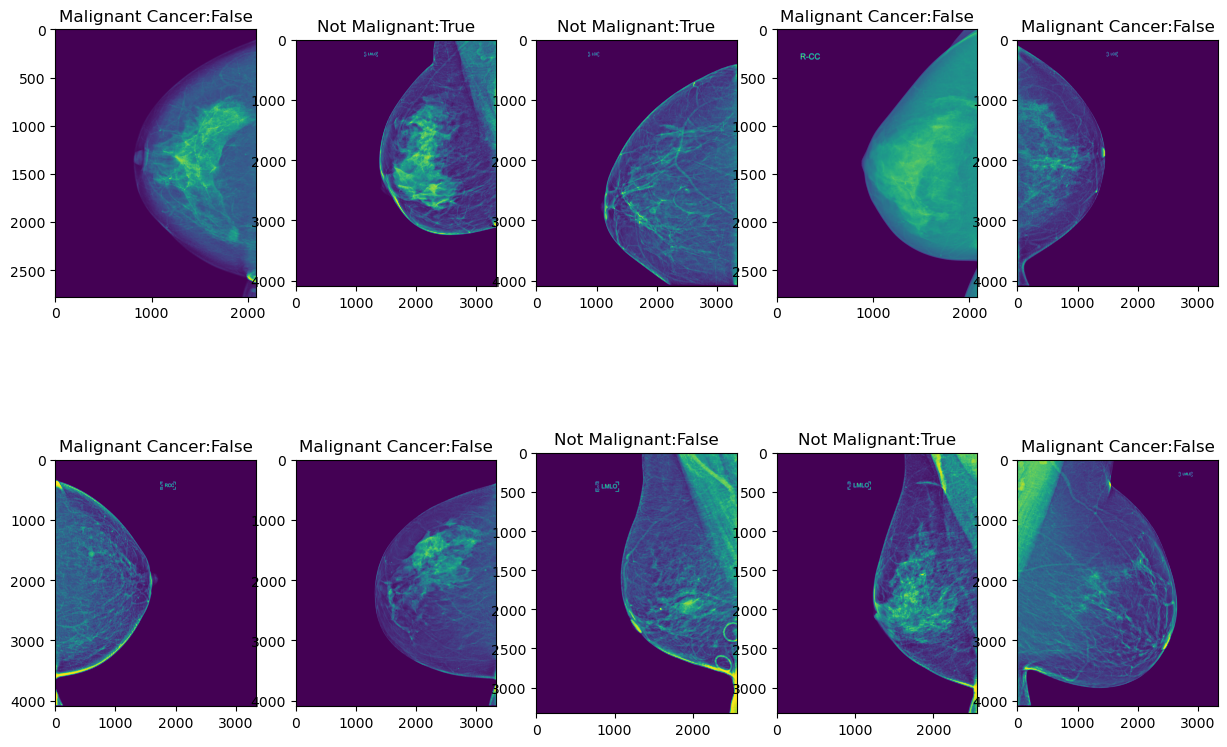

In [56]:
model.cpu().eval()
dataiter = iter(val_loader)
images, labels = dataiter.next()
arthopod_types = {0: 'Not Malignant', 1: 'Malignant Cancer'}
# Viewing data examples used for training
fig, axis = plt.subplots(2, 5, figsize = (15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image_visual, label_visual = val_visual[i]
        image, label = images[i], labels[i]
        ax.imshow(img_display(image_visual.squeeze(0))) # add image
        image_tensor = image.unsqueeze_(0)
        output_ = model(image_tensor)
        output_ = torch.sigmoid(output_)
        if output_.item() > 0.5:
            k = (label.item() == 1)
        else:
            k = (label.item() == 0)
        ax.set_title(str(arthopod_types[label.item()]) + ":" + str(k)) # add label

**Because of huge computational costs, this notebook must be ended here. To see coding for visualization of results and prediction of test data, please visit [PyTorch and RSNA Screening Mammography](https://www.kaggle.com/code/gokifujiya/pytorch-and-rsna-screening-mammography).**

## Credits

Please go and visit these below mentioned notebooks and support their works and advices. Without the help of the below mentioned notebooks and advices, it would have been much difficult for me to approach the solution.
1. [how to read .dcm (DICOM) data](https://www.kaggle.com/code/micheldc55/how-to-read-dcm-dicom-data)
2. [PyTorch-Tutorial (The Classification)](https://www.kaggle.com/code/basu369victor/pytorch-tutorial-the-classification)
3. [FFT with resnet50](https://www.kaggle.com/code/kilogrand/fft-with-resnet50/notebook#import)
4. [rsna-2022-whl](https://www.kaggle.com/code/vslaykovsky/rsna-2022-whl)
5. [RBCD Downloads](https://www.kaggle.com/code/clemchris/rbcd-downloads)
6. [Thomas Konstantin](https://www.kaggle.com/code/gokifujiya/pytorch-and-rsna-screening-mammography/comments)